In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import squidpy as sq
import anndata as ad
import seaborn as sns
import simstpy as sim
import matplotlib.pyplot as plt

In [2]:
SPATIAL_PATTERNS = [
    "human_DLPFC_151508",
    "human_DLPFC_151674",
    "mouse_cerebellum",
    "mouse_coronal_slices",
    "breast_tumor"
]

In [3]:
adata = sc.read_h5ad(f"./reference/151507.h5ad")
adata

AnnData object with n_obs × n_vars = 4221 × 15818
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
library_size_params = sim.rna.fit_library_size(adata.layers["counts"])
gene_mean_params = sim.rna.fit_mean_expression_gamma(adata.X, q=0.99)

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


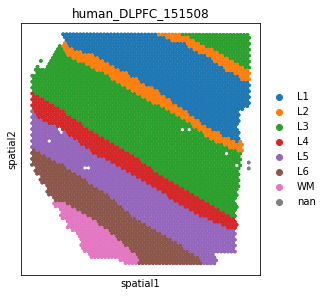

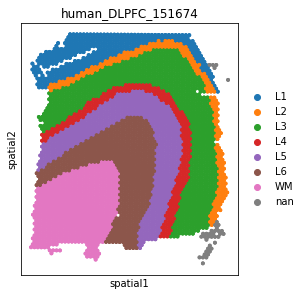

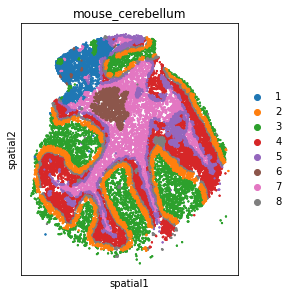

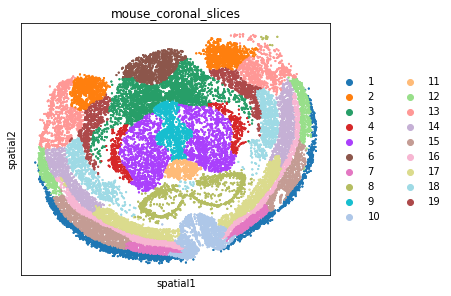

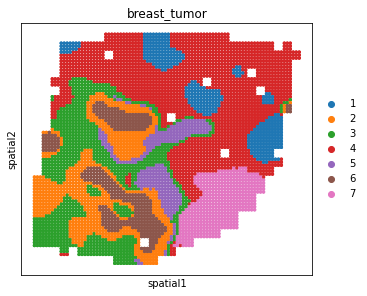

In [5]:
for i, spatial_pattern in enumerate(SPATIAL_PATTERNS):
    df_spatial = sim.read_spatial_pattern(f"{spatial_pattern}")
    
    sim_adata = sim.rna.simulate_multi_group(library_size_params,
                                             gene_mean_params, 
                                             n_cells=len(df_spatial), 
                                             n_genes=10000,
                                             df_spatial=df_spatial, 
                                             group_name="spatial_cluster", 
                                             n_marker_genes=100)
    
    sim_adata = sim.add_spatial_assay(sim_adata, df_spatial=df_spatial, library_id=spatial_pattern)
    
    sim_adata.layers['counts'] = sim_adata.X.copy()
    sc.pp.normalize_total(sim_adata, target_sum=1e4)
    sc.pp.log1p(sim_adata)
    
    sq.pl.spatial_scatter(sim_adata, shape=None, color=["spatial_cluster"], title=spatial_pattern)
    
    sim_adata.write_h5ad(f"./simulated/{spatial_pattern}.h5ad")